# High-Dimensional-Deep-Learning - 5A
## Mini-project n° 1 – Qui a peint ce tableau?

Maïmouna Gadji, Phuc-Luan Nguyen, Maddie Perez et Julia Soufflet

# Introduction

Le but de ce projet est de développer un modèle capable de prédire l'artiste d'une œuvre d'art à partir de son image, dans le cadre du défi Art Challenge. Nous utiliserons un jeu de données comportant des œuvres d'art en haute et basse qualité, ainsi que des informations sur les artistes. L’objectif est de construire un réseau de neurones convolutifs (CNN) pour effectuer cette tâche de classification d'images. Ce rapport présente la démarche suivie, notamment le choix des images à étudier, l'architecture du réseau utilisée, ainsi que les différentes étapes de prétraitement et d'entraînement du modèle.

In [40]:
# Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image


# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# tf.config.list_physical_devices()
[k.device_type for k in tf.config.list_physical_devices()]

2024-11-18 11:28:49.531712: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


['CPU']

## Présentation du Dataset

Le jeu de données utilisé provient du site *artchallenge.ru* et se compose de plusieurs éléments essentiels :

1. **artists.csv** :  
   Ce fichier contient des informations sur les artistes, y compris :
   - Le nom de l'artiste
   - La biographie de l'artiste
   - Le style de peinture de l'artiste
   - Les années de naissance et de mort
   - Le nombre d’œuvres d'art prises en compte
   - Un lien vers la page Wikipédia de l'artiste

2. **images_hq** :  
   Ce dossier contient les œuvres en haute qualité (HD), classées par artiste. 
3. **images_lq** :  
   Ce dossier contient les mêmes œuvres, mais en basse résolution.



## Justification du choix des images en haute qualité (images_hq)

Dans ce projet, nous avons choisi d'utiliser les images en haute qualité (`images_hq`) plutôt que celles en basse qualité (`images_lq`). Ce choix est basé sur plusieurs raisons clés :

1. **Meilleure précision pour le modèle** :
   - Les images en haute qualité contiennent plus de détails visuels, ce qui permet à un modèle de réseau de neurones, tel qu'un CNN, d'extraire des caractéristiques plus fines et plus pertinentes pour la classification des œuvres d'art.

2. **Amélioration de la généralisation** :
   - Mieux capturer les nuances subtiles des œuvres d'art. Cela pourrait améliorer la capacité du modèle à généraliser et à faire des prédictions plus précises sur des images inconnues.

3. **Préparation pour des transformations d'images** :
   - Travailler avec des images de haute qualité permet de maintenir une bonne précision après ces transformations, contrairement aux images de faible qualité qui risquent de perdre des informations importantes après les modifications.




## Organisation des fichiers et création d'un dataframe

La structure des fichiers du projet est organisée comme suit :

```projet/ 
├── data/ 
│   ├── artiste1/
│   │   ├── oeuvre1.jpg
│   │   ├── oeuvre2.jpg
│   ├── artiste2/
│   │   ├── oeuvre1.jpg
│   ├── artists.csv
└── notebook.ipynb ```

Aprés avoir importé les fichiers, on crée un dataframe (`total_df`)  qui contient la colonne (`filename`) avec les noms des images et la colonne (`auteur`) avec le nom des auteurs associés

In [49]:
import os
import shutil
import pandas as pd

# Vérifie si le dossier "data" existe, et le supprime s'il est présent.
if os.path.exists("data"):
    shutil.rmtree("data")  # Supprime le dossier et tout son contenu

# Définition du chemin vers le dossier contenant les images des auteurs.
path = "./images_hq/"

# Si le dossier "data" n'existe pas, il est créé.
if not os.path.exists("data"):
    os.mkdir("data")  # Crée un nouveau dossier "data"

# Initialisation des listes pour stocker les noms de fichiers et les labels.
filenames = []  # Liste pour stocker les noms des fichiers
authors = []    # Liste pour stocker les noms des auteurs

# Parcours des sous-dossiers d'auteurs dans le dossier `path`.
for author_folder in os.listdir(path):
    # Chemin complet vers le sous-dossier.
    author_path = os.path.join(path, author_folder)

    # Vérifie que c'est un dossier (pour ignorer les fichiers non pertinents).
    if os.path.isdir(author_path):
        # Crée un sous-dossier correspondant dans "data".
        dest_folder = os.path.join("data", author_folder)
        if not os.path.exists(dest_folder):
            os.mkdir(dest_folder)

        # Parcours de chaque fichier dans le sous-dossier de l'auteur.
        for image_filename in os.listdir(author_path):
            # Vérifie que c'est bien un fichier image (par exemple, extension `.jpg`).
            if image_filename.endswith('.jpg'):
                # Chemins source et destination.
                src = os.path.join(author_path, image_filename)  # Chemin source
                dst = os.path.join(dest_folder, image_filename)  # Chemin destination

                # Copie le fichier vers le sous-dossier dans "data".
                shutil.copyfile(src, dst)

                # Ajoute le nom du fichier et le label correspondant aux listes.
                filenames.append(os.path.join(author_folder, image_filename))  # Inclut le chemin relatif
                authors.append(author_folder)  # Nom de l'auteur (le nom du sous-dossier)

# Création d'un DataFrame pandas avec les informations collectées.
total_df = pd.DataFrame({
    "filename": filenames,
    "auteur": authors
})




### Exploration du dataset

In [50]:
# Affiche un aperçu du DataFrame pour vérification.
print(total_df.head())

# Enregistre le DataFrame dans un fichier CSV si nécessaire.
total_df.to_csv("train_data.csv", index=False)

                      filename     auteur
0  Paul_Klee/Paul_Klee_175.jpg  Paul_Klee
1  Paul_Klee/Paul_Klee_112.jpg  Paul_Klee
2    Paul_Klee/Paul_Klee_8.jpg  Paul_Klee
3  Paul_Klee/Paul_Klee_123.jpg  Paul_Klee
4   Paul_Klee/Paul_Klee_55.jpg  Paul_Klee


In [52]:
total_df.shape

(8446, 2)

Nous avons 8446 images dans notre dataset

Nous allons visualiser la répartition des labels ('auteur') dans le dataset en comptant le nombre d'occurrences de chaque auteur et en affichant un graphique à barres trié de manière décroissante. Cela permet d'analyser la distribution des œuvres par auteur

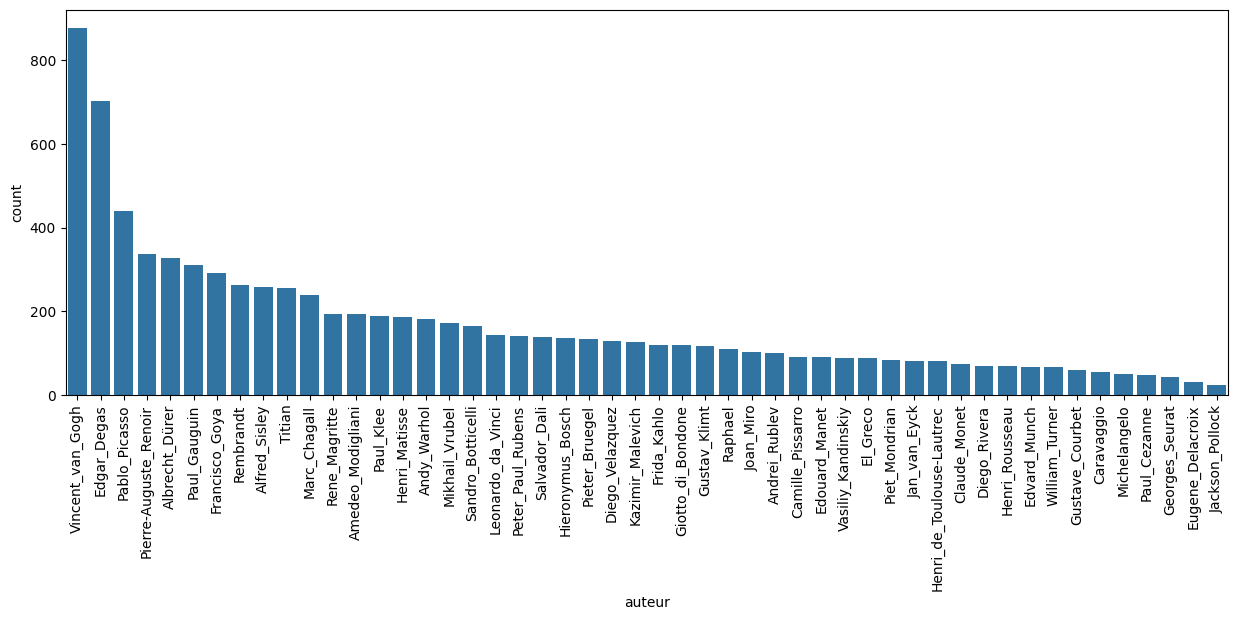

In [56]:
# Compter les occurrences des auteurs et trier de manière décroissante
author_counts = total_df["auteur"].value_counts()

# Créer le plot en suivant cet ordre
plt.figure(figsize=(15, 5))
sns.countplot(x=total_df["auteur"], order=author_counts.index)
plt.xticks(rotation=90)
plt.show()

In [ ]:
sorted_data = total_df.iloc[:, 1].value_counts(ascending=False)
sorted_data

auteur
VincentvanGogh             877
EdgarDegas                 702
PabloPicasso               439
Pierre-AugusteRenoir       336
AlbrechtDürer              328
PaulGauguin                311
FranciscoGoya              291
Rembrandt                  262
AlfredSisley               259
Titian                     255
MarcChagall                239
ReneMagritte               194
AmedeoModigliani           193
PaulKlee                   188
HenriMatisse               186
AndyWarhol                 181
MikhailVrubel              171
SandroBotticelli           164
LeonardodaVinci            143
PeterPaulRubens            141
SalvadorDali               139
HieronymusBosch            137
PieterBruegel              134
DiegoVelazquez             128
KazimirMalevich            126
FridaKahlo                 120
GiottodiBondone            119
GustavKlimt                117
Raphael                    109
JoanMiro                   102
AndreiRublev                99
CamillePissarro             91
E

**Analyse**: Nous constatons que nos données présentent un déséquilibre dans la répartition des étiquettes. Cela peut entraîner :
   + **Déséquilibre de la précision entre les classes** : Lorsque certaines classes ont beaucoup moins d'exemples que d'autres, le modèle CNN peut biaiser ses prédictions en faveur des classes les plus représentées. Cela signifie que le modèle aura une précision moindre pour les classes sous-représentées.
  


**Nous allons alors réduire le nombre d'auteurs. Nous allons garder ceux qui ont au moins 150 tableaux. Nous allons egalement réduire le nombre de tableaux pour certains auteurs en mettant un seuil egal à 450** 

In [57]:
auteur_counts = total_df['auteur'].value_counts()

# Filtrer les auteurs qui ont au moins 150 images
auteurs_150_plus = auteur_counts[auteur_counts >= 150].index
filtered_df = total_df[total_df['auteur'].isin(auteurs_150_plus)]

# Limiter à un maximum de 450 images par auteur
def reduce_images(df, max_images=450):
    if len(df) > max_images:
        return df.sample(n=max_images, random_state=42)  # Échantillonnage aléatoire
    return df

# Appliquer la réduction pour chaque auteur
balanced_df = filtered_df.groupby('auteur').apply(reduce_images).reset_index(drop=True)

# Afficher le résultat
print("Taille du DataFrame après équilibrage :", balanced_df.shape)
print(balanced_df['auteur'].value_counts())

Taille du DataFrame après équilibrage : (4897, 2)
auteur
Vincent_van_Gogh         450
Edgar_Degas              450
Pablo_Picasso            439
Pierre-Auguste_Renoir    336
Albrecht_Dürer           328
Paul_Gauguin             311
Francisco_Goya           291
Rembrandt                262
Alfred_Sisley            259
Titian                   255
Marc_Chagall             239
Rene_Magritte            194
Amedeo_Modigliani        193
Paul_Klee                188
Henri_Matisse            186
Andy_Warhol              181
Mikhail_Vrubel           171
Sandro_Botticelli        164
Name: count, dtype: int64


<ipython-input-57-2787672a6007>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = filtered_df.groupby('auteur').apply(reduce_images).reset_index(drop=True)


In [58]:
total_df=balanced_df
nclasses=len(total_df.auteur.unique())
total_df.shape, nclasses


((4897, 2), 18)

**Nous nous retrouvons maintenant avec 18 Auteurs et 4897 données**

## Visualisation des images

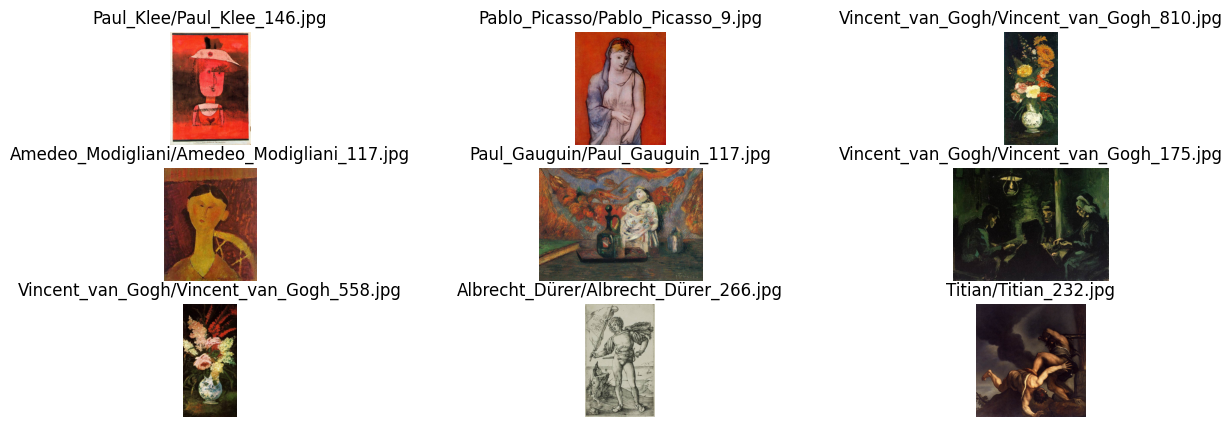

In [60]:
from tensorflow.keras.utils import load_img, img_to_array
fig,axe=plt.subplots(3,3,figsize=(15,5))

for i in range(3):
    for j in range(3):
        filename = rd.choice(total_df['filename'])
        img = load_img("data/" + filename)

          # Sélectionne une image appartenant à la classe k

        # Affiche l'image sur l'axe correspondant
        axe[i, j].imshow(img) 
        axe[i, j].set_title(filename)  # Ajoute un titre pour chaque sous-graphe
        axe[i, j].axis('off')


## Pretraitement des données

### Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode the 'category' column
total_df['auteur'] = label_encoder.fit_transform(total_df['auteur'])
total_df["auteur"]=total_df["auteur"].astype("str")

# Display the updated DataFrame
total_df.head()

filename auteur
0    Albrecht_Dürer_1.jpg      0
1   Albrecht_Dürer_10.jpg      0
2  Albrecht_Dürer_100.jpg      0
3  Albrecht_Dürer_101.jpg      0
4  Albrecht_Dürer_102.jpg      0

In [65]:
total_df.dtypes

filename    object
auteur      object
dtype: object

### Division du dataset

Ce code permet de diviser le jeu de données (`total_df`) en trois sous-ensembles : 60% pour l'entraînement, 20% pour le test, puis l'ensemble et 20% pour la validation.




In [63]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)


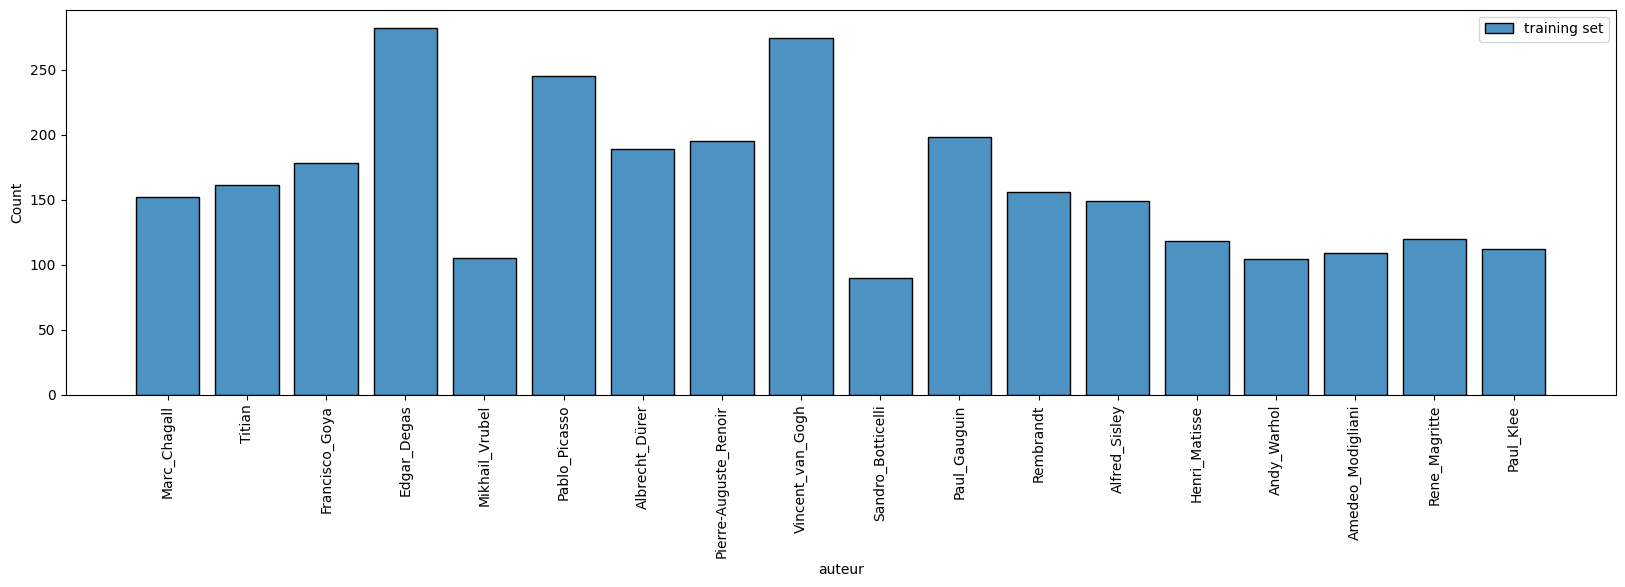

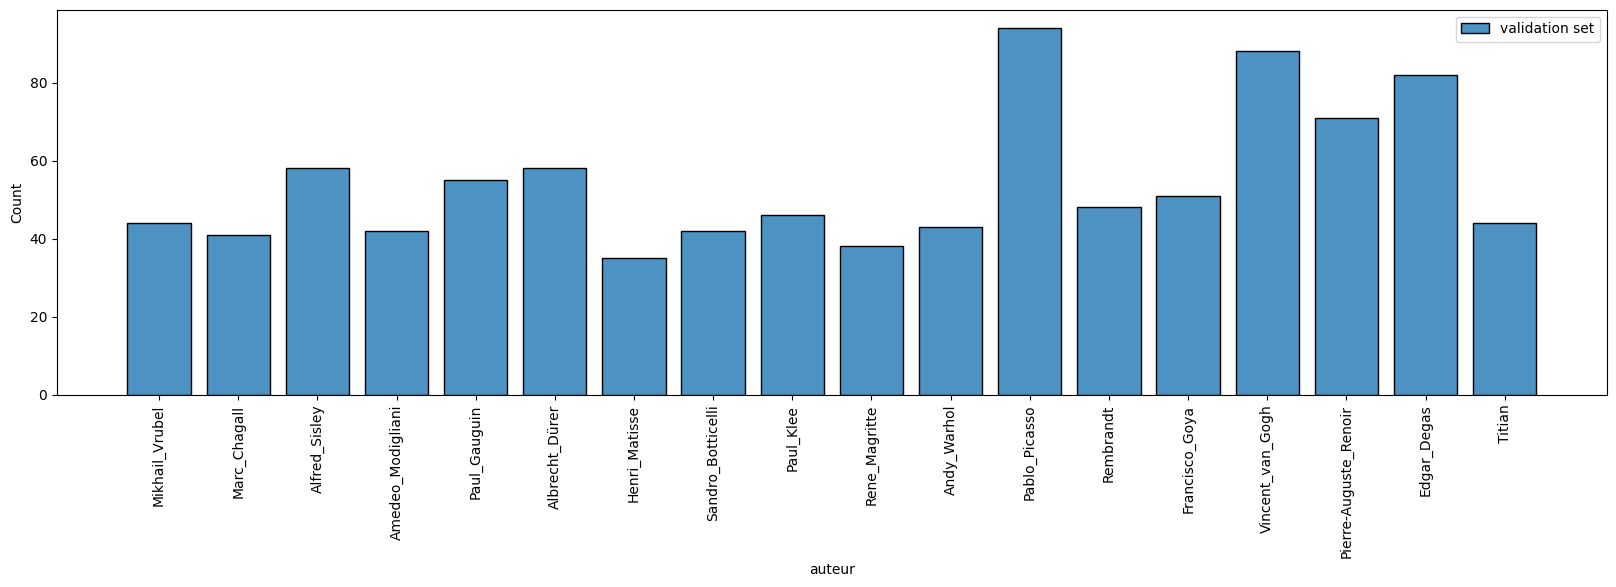

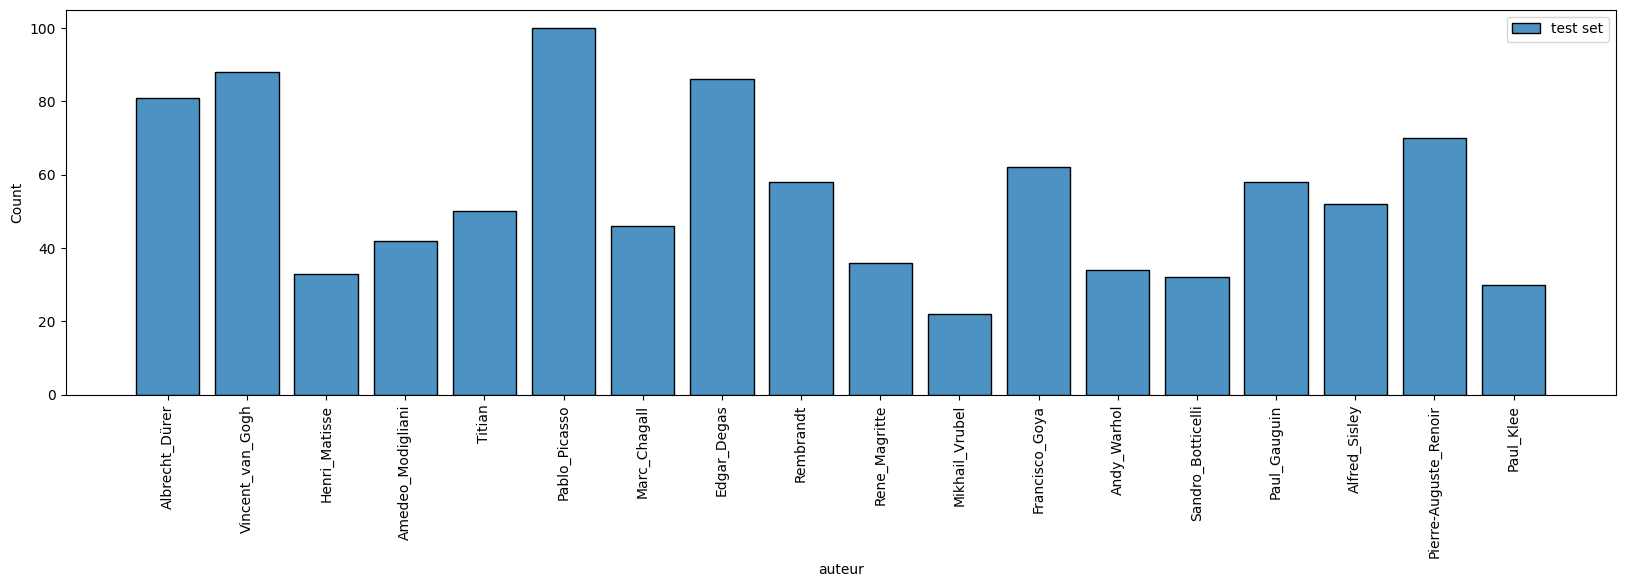

In [67]:
plt.figure(figsize=(20,5))

sns.histplot(train_df.iloc[:,1],label="training set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(20,5))
sns.histplot(val_df.iloc[:,1],label="validation set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(20,5))
sns.histplot(test_df.iloc[:,1],label="test set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()

Les histogrammes dans les différents datasets montrent un bon équilibre entre les différents auteurs. Cela permettra à l'entraînement du modèle de se faire de manière équitable, en évitant un biais vers certains auteurs, et d'assurer une meilleure performance sur les données de test et de validation.


### Redimensionnement des images

A l'aide de boxplots, nous allons observer les dimensions des différentes images du dataset.

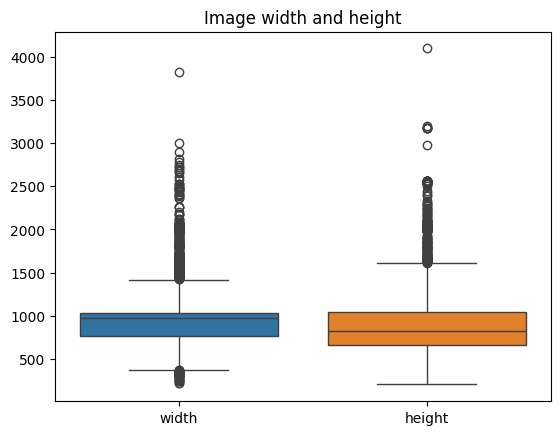

In [61]:
img_size = np.zeros((total_df.shape[0],2))
for i, filename in enumerate(total_df['filename']) :
    img = img_to_array( load_img("data/"+filename) )
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()


**Nous constatons que les dimensions fluctuent, alors que nous avons besoin d'images de mêmes dimensions pour notre modèle. Afin de garantir une entrée cohérente pour le modèle, il est donc nécessaire de redimensionner toutes les images à une taille uniforme de 224x224, ce qui est la taille d'entrée recommandée pour VGG16**



In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 32 # Nombre d'images à traiter à chaque itération de l'entraînement.
img_width = 224 # Largeur cible des images après redimensionnement.
img_height = 224 # Hauteur cible des images après redimensionnement.

# Crée un générateur d'images pour l'ensemble d'entraînement en normalisant les pixels (valeurs entre 0 et 1).
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
     "data/",
    x_col = 'filename',
    y_col = 'auteur',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
     "data/",
    x_col = 'filename',
    y_col = 'auteur',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
     "data/",
    x_col = 'filename',
    y_col = 'auteur',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)


Found 2937 validated image filenames belonging to 18 classes.
Found 980 validated image filenames belonging to 18 classes.
Found 980 validated image filenames belonging to 18 classes.


### Visualisation des images redimensionnées

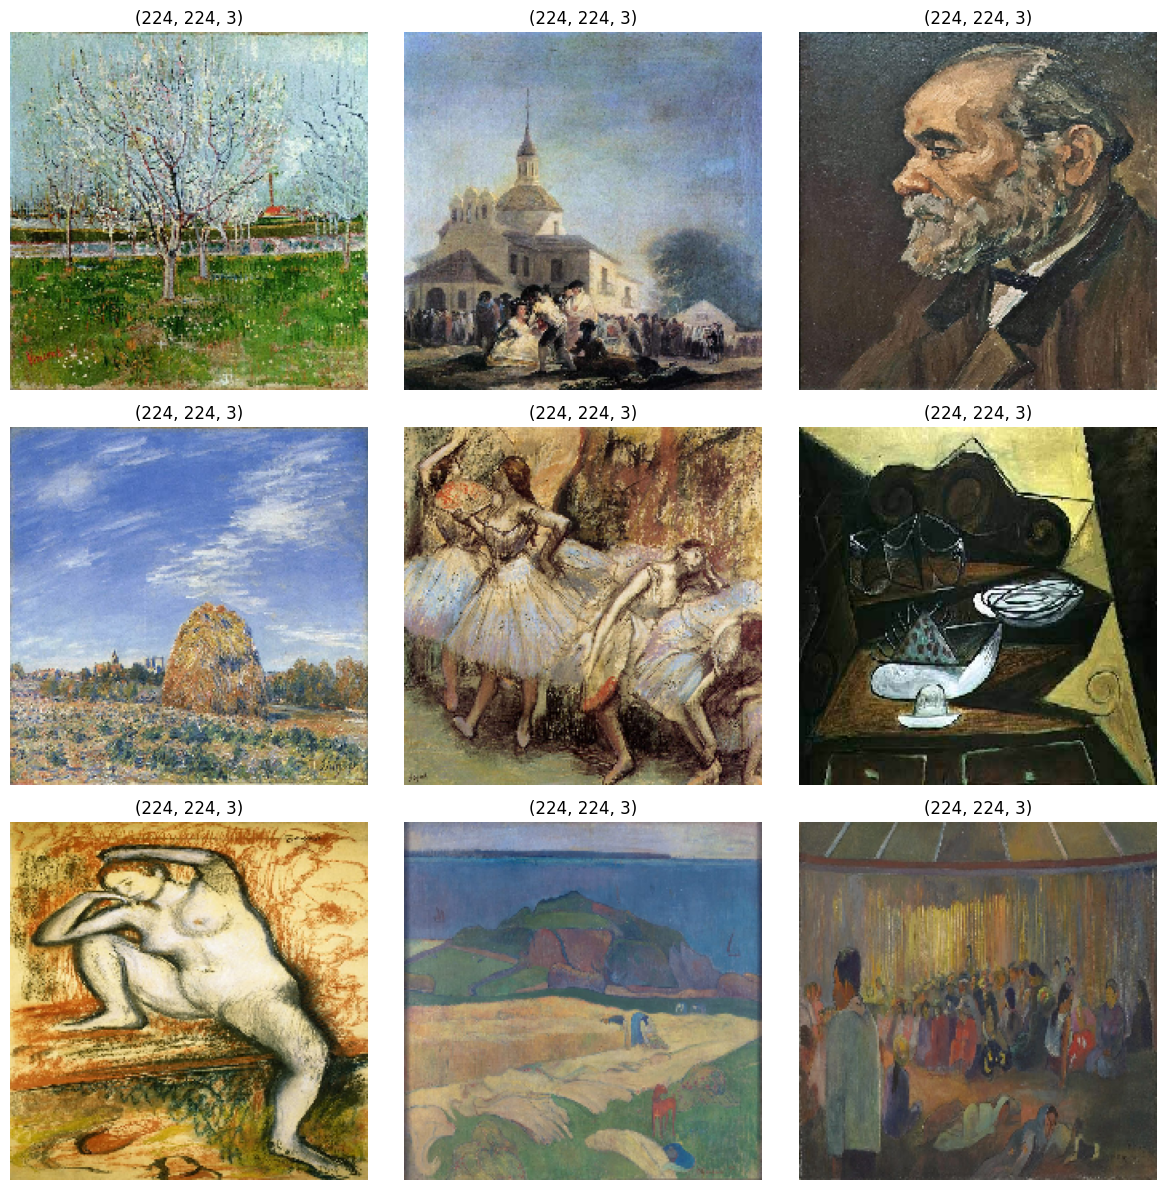

In [66]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]

        plt.title(str(img.shape))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

## First approach: Transfer Learning avec VGG16

**VGG16**

**VGG16** est un modèle de réseau de neurones convolutifs (CNN) profond développé composé de 16 couches, d'où son nom. Le modèle VGG16 a été pré-entraîné sur le dataset ImageNet, contenant des millions d'images réparties sur 1000 classes, ce qui lui permet d'extraire des caractéristiques visuelles de manière très performante.

**Transfer Learning**

Le **transfer learning** est une technique d'apprentissage automatique où un modèle préalablement entraîné sur une tâche donnée est réutilisé pour une nouvelle tâche. Dans ce projet, nous allons utiliser **VGG16** pour effectuer du transfer learning. Nous réutiliserons les caractéristiques (features) extraites par VGG16, puis nous ajouterons une couche entièrement connectée (fully connected layer) pour effectuer la classification des œuvres d'art en fonction de ces caractéristiques.


In [68]:
from tensorflow.keras.applications import VGG16

In [69]:
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Extraction des features

In [ ]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0], -1))

validation_features = conv_base.predict(val_generator)
validation_features = np.reshape(validation_features,(validation_features.shape[0], -1))

/home/gadj/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step


In [ ]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,1]])

validation_data = val_df.to_numpy()
y_validation = np.array([int(numeric_string) for numeric_string in validation_data[:,1]])

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=nclasses)
y_validation = to_categorical(y_validation, num_classes=nclasses)

#### Fully connected layers pour la classification

In [ ]:
vgg_mlp = Sequential()
vgg_mlp.add( Input((train_features.shape[1],)) )
vgg_mlp.add(Dense(256, activation='relu'))
vgg_mlp.add(Dropout(0.5))
vgg_mlp.add(Dense(nclasses, activation='softmax'))

vgg_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,427,410 (24.52 MB)

 Trainable params: 6,427,410 (24.52 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modéle

In [ ]:
epochs = 50

vgg_mlp.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_mlp = time.time()
vgg_mlp_history = vgg_mlp.fit(
    train_features, y_train,
    validation_data = (validation_features, y_validation),
    epochs = epochs
)
t_learning_vgg_mlp = time.time() - t_learning_vgg_mlp

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_mlp))

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.1293 - loss: 2.6880 - val_accuracy: 0.0837 - val_loss: 2.9592
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1232 - loss: 2.6769 - val_accuracy: 0.0827 - val_loss: 2.9850
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1251 - loss: 2.6854 - val_accuracy: 0.0827 - val_loss: 2.9951
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1225 - loss: 2.6886 - val_accuracy: 0.0827 - val_loss: 3.0015
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1263 - loss: 2.6630 - val_accuracy: 0.0837 - val_loss: 3.0173
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1247 - loss: 2.6654 - val_accuracy: 0.0816 - val_loss: 3.0446
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1232 - loss: 2.6706 - val_accuracy: 0.0816 - val_loss: 3.0437
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1198 - loss: 2.6894 - val_accuracy: 0.0867 - v

In [77]:

def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

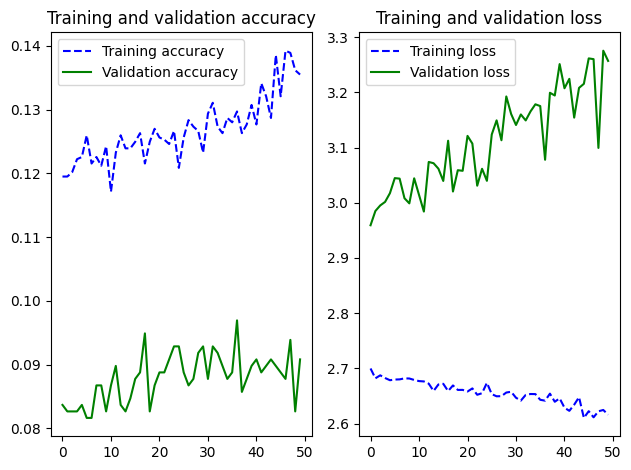

In [ ]:
plot_training_analysis(vgg_mlp_history)

**Analyse:** Avec 50 epochs,le modèle ne performe pas correctement, ni sur l'ensemble d'entraînement ni sur l'ensemble de validation: **il n'apprend pas suffisamment des données**

In [ ]:
t_prediction_vgg_mlp = time.time()

score_vgg_mlp_train = vgg_mlp.evaluate(train_features, y_train)
score_vgg_mlp_validation = vgg_mlp.evaluate(validation_features, y_validation)

t_prediction_vgg_mlp = time.time() - t_prediction_vgg_mlp

print('Train accuracy:', score_vgg_mlp_train[1])
print('Validation accuracy:', score_vgg_mlp_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_mlp )

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1903 - loss: 2.4451
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0820 - loss: 3.2517
Train accuracy: 0.18113721907138824
Validation accuracy: 0.09081632643938065
Time Prediction: 1.36 seconds


# Second Approach: Transfer learning with data augmentation

**Pour améliorer cela, nous allons procéder à une augmentation des données afin d'enrichir l'ensemble d'apprentissage et d'améliorer la capacité du modèle à généraliser**

In [70]:
# Data Augmentation using ImageDataGenerator
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation aléatoire de 20 degrés
    width_shift_range=0.2,  # Décalage horizontal aléatoire de 20%
    height_shift_range=0.2,  # Décalage vertical aléatoire de 20%
    shear_range=0.2,  # Déformation par cisaillement aléatoire de 20%
    zoom_range=0.2,  # Zoom aléatoire de 20%
    horizontal_flip=True,  # Retournement horizontal aléatoire
    fill_mode='nearest'  # Méthode de remplissage pour les pixels manquants
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    "data/",
    x_col='filename',
    y_col='auteur',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size
)

Found 2937 validated image filenames belonging to 18 classes.


#### Visualisation des images génerées

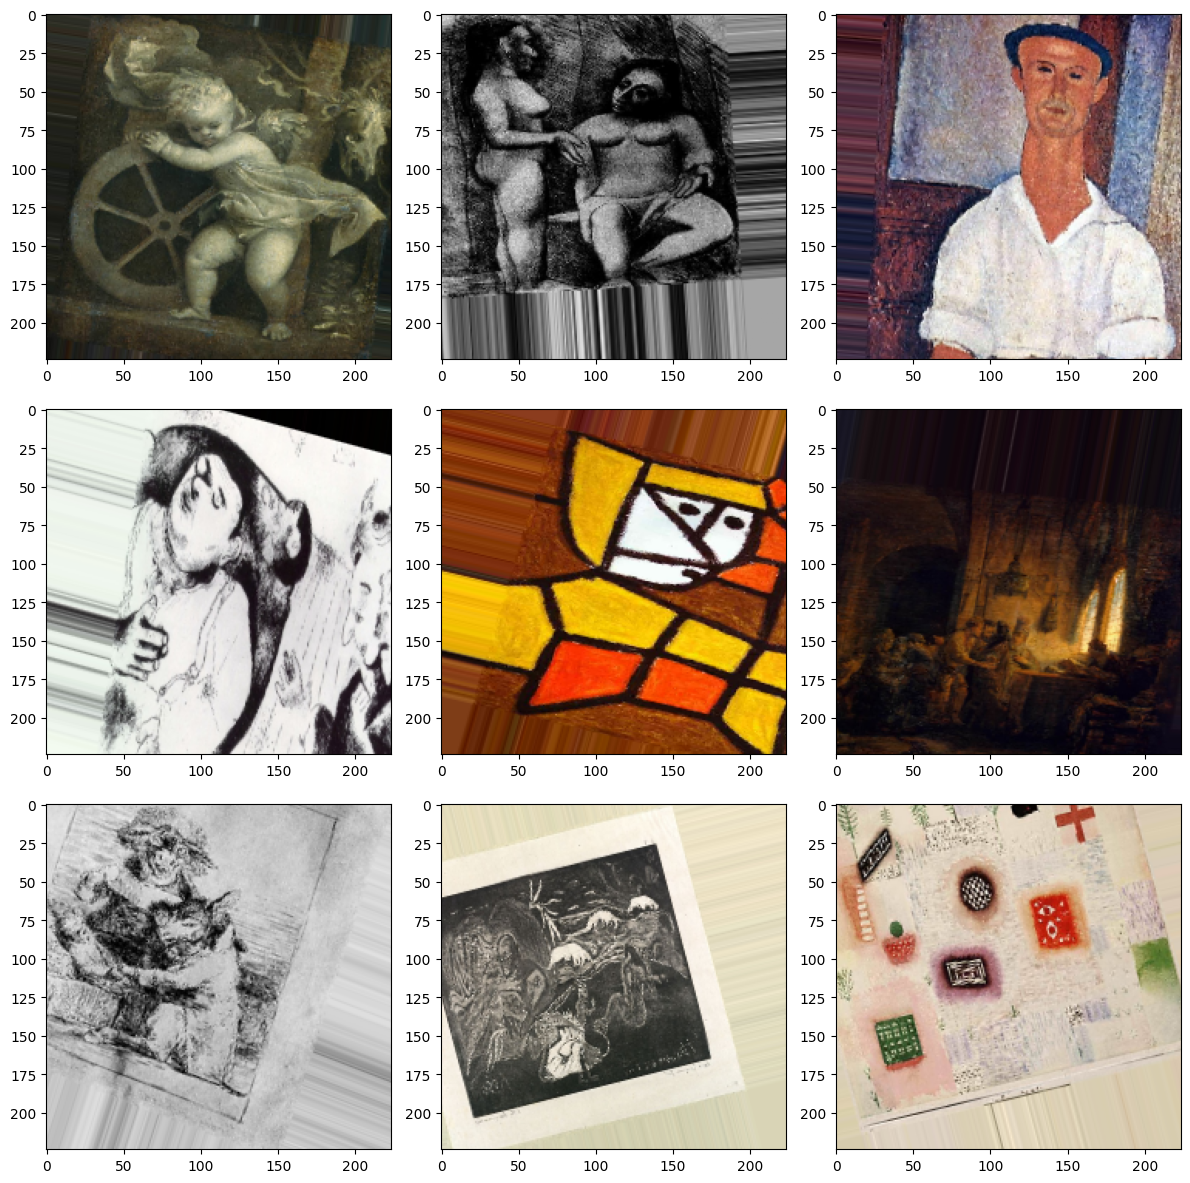

In [ ]:
plt.figure(figsize=(12, 12))

example_x, example_y = next(train_generator_augmented)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i])
    #plt.title(labels.get(example_y[i]))

plt.tight_layout()
plt.show()

#### Fully connected layers pour la classification

In [136]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(nclasses, activation='softmax'))

vgg_combined.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 13,506,834 (51.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [137]:
conv_base.trainable = False
vgg_combined.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 6,427,410 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [138]:
epochs = 10

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = val_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 550ms/step - accuracy: 0.6281 - loss: 1.2439 - val_accuracy: 0.6949 - val_loss: 1.2586
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 536ms/step - accuracy: 0.9068 - loss: 0.2962 - val_accuracy: 0.7337 - val_loss: 1.3620
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 539ms/step - accuracy: 0.9023 - loss: 0.3080 - val_accuracy: 0.6969 - val_loss: 1.5691
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 0.9352 - loss: 0.2062 - val_accuracy: 0.7204 - val_loss: 1.4646
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 538ms/step - accuracy: 0.9477 - loss: 0.1777 - val_accuracy: 0.6878 - val_loss: 1.8464
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 0.9394 - loss: 0.1687 - val_accuracy: 0.7122 - val_loss: 1.7943
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 544ms/step - accuracy: 0.9502 - loss: 0.1590 - val_accuracy: 0.7214 - val_loss: 1.7473
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 544ms/step - accuracy: 0.9505 - loss: 0.1405 - val_accu

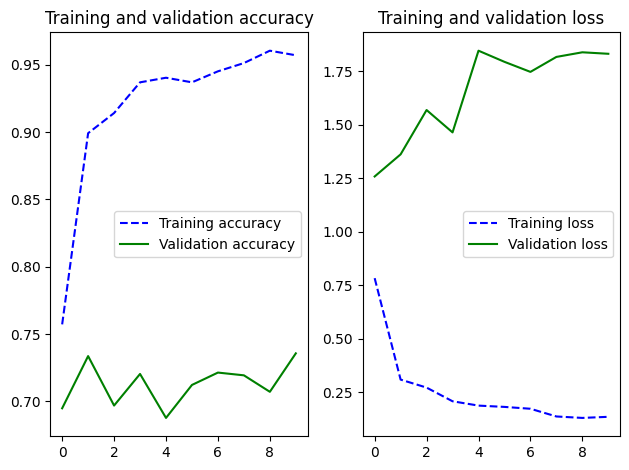

In [139]:
plot_training_analysis(vgg_combined_history)

In [140]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(val_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)



t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 509ms/step - accuracy: 0.9656 - loss: 0.1030
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.7245 - loss: 1.8898
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.7177 - loss: 1.6748
Train accuracy: 0.9605039358139038
Validation accuracy: 0.7357142567634583
Test accuracy: 0.7204081416130066
Time Prediction: 62.17 seconds


**Nous atteignons une précision de test de 72%, ce qui est nettement plus satisfaisant comparé au modèle précédent. Cependant, nous pensons pouvoir encore améliorer cette performance en effectuant un fine-tuning sur la dernière couche de VGG16.**


# Third Approach: FineTunning Transfer learning with data augmentation

Le **fine-tuning** consiste à ajuster les poids des dernières couches d'un modèle pré-entraîné pour mieux l'adapter à une tâche spécifique.


In [170]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(nclasses, activation='softmax'))

vgg_combined.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 13,506,834 (51.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [171]:
conv_base.trainable = True

for layer in conv_base.layers[:15]:
    layer.trainable = False

vgg_combined.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 13,506,834 (51.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [172]:
epochs = 10

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=1e-4), # Reduced learning rates to avoid smashing everything and risking overfitting
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = val_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 549ms/step - accuracy: 0.5476 - loss: 1.5018 - val_accuracy: 0.6337 - val_loss: 1.4571
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 0.8690 - loss: 0.3826 - val_accuracy: 0.7112 - val_loss: 1.1241
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 542ms/step - accuracy: 0.9069 - loss: 0.2585 - val_accuracy: 0.6827 - val_loss: 1.3950
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 543ms/step - accuracy: 0.9082 - loss: 0.2596 - val_accuracy: 0.6449 - val_loss: 1.7136
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 544ms/step - accuracy: 0.9446 - loss: 0.1742 - val_accuracy: 0.6827 - val_loss: 1.3448
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 544ms/step - accuracy: 0.9528 - loss: 0.1367 - val_accuracy: 0.7235 - val_loss: 1.3747
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 543ms/step - accuracy: 0.9617 - loss: 0.1293 - val_accuracy: 0.6622 - val_loss: 1.6243
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 541ms/step - accuracy: 0.9419 - loss: 0.1751 - val_accu

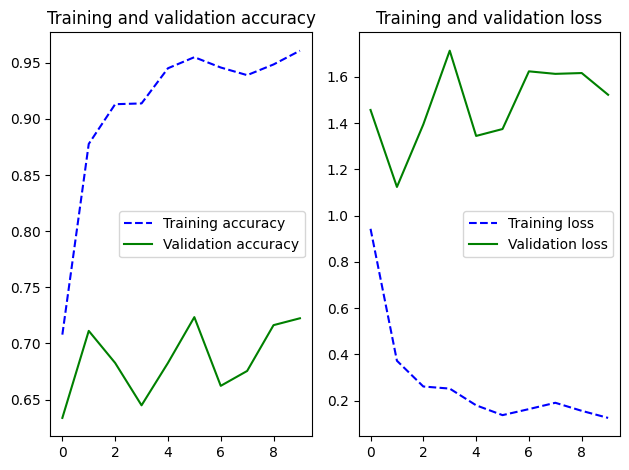

In [173]:
plot_training_analysis(vgg_combined_tuned_history)

In [174]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(val_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)



t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 514ms/step - accuracy: 0.9639 - loss: 0.1045
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.7068 - loss: 1.4851
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.7388 - loss: 1.4913
Train accuracy: 0.9679945707321167
Validation accuracy: 0.722449004650116
Test accuracy: 0.7438775300979614
Time Prediction: 62.62 seconds


**La précision sur l'ensemble de test atteint 74%, le fine-tuning n'a pas permis d'améliorer significativement les performances du modèle.**



# Explication possible à cette précision

Prédictions en cours: 100%|██████████| 980/980 [01:03<00:00, 15.48image/s]


Rapport de Classification :

                       precision    recall  f1-score   support

       Albrecht_Dürer       0.80      0.96      0.87        81
        Alfred_Sisley       0.93      0.79      0.85        52
    Amedeo_Modigliani       0.83      0.93      0.88        42
          Andy_Warhol       0.78      0.62      0.69        34
          Edgar_Degas       0.79      0.78      0.78        86
       Francisco_Goya       0.71      0.71      0.71        62
        Henri_Matisse       0.40      0.76      0.53        33
         Marc_Chagall       0.85      0.72      0.78        46
       Mikhail_Vrubel       0.64      0.32      0.42        22
        Pablo_Picasso       0.69      0.71      0.70       100
         Paul_Gauguin       0.77      0.83      0.80        58
            Paul_Klee       0.66      0.63      0.64        30
Pierre-Auguste_Renoir       0.86      0.63      0.73        70
            Rembrandt       0.72      0.84      0.78        58
        Rene_Magritte    

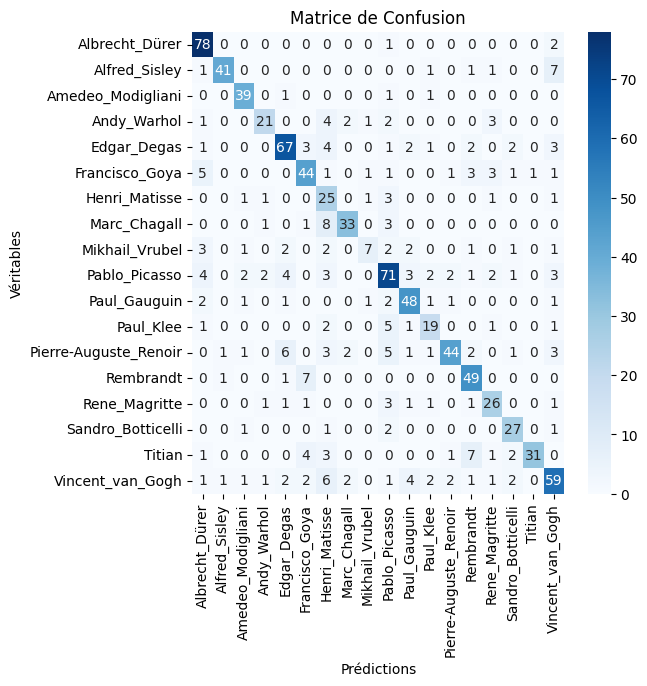

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # Importer tqdm

# Prédictions sur l'ensemble de test
true_labels = []
predicted_labels = []

# Obtenez les noms des classes à partir du générateur
class_names = {v: k for k, v in test_generator.class_indices.items()}  # Inverser le dictionnaire pour obtenir l'indice -> nom

# Initialiser la barre de progression avec tqdm pour le nombre total d'images
for idx in tqdm(range(len(test_generator.filenames)), desc="Prédictions en cours", unit="image"):
    image_path = "./data/" + test_generator.filenames[idx]
    true_artist_index = test_generator.labels[idx]
    true_labels.append(class_names[true_artist_index])  # Remplacer par le nom de l'artiste

    img = image.load_img(image_path, target_size=(224, 224))  # Taille d'image utilisée par le modèle
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension batch
    img_array /= 255.0  # Normalisation

    # Prédiction de l'artiste sans afficher la barre de chargement interne du modèle
    predictions = vgg_combined.predict(img_array, verbose=0)  # Mettre verbose=0 pour désactiver la barre interne
    predicted_artist_index = np.argmax(predictions, axis=1)[0]
    predicted_labels.append(class_names[predicted_artist_index])  # Remplacer par le nom de l'artiste

# Calcul du rapport de classification
report = classification_report(true_labels, predicted_labels, target_names=class_names.values())
print("Rapport de Classification :\n")
print(report)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de Confusion')
plt.show()


**Bien que nous ayons tenté d'équilibrer le dataset, certains auteurs, comme Mikhail Vrubel et Henri Matisse, disposent d'un nombre limité de peintures. Cela se reflète dans leurs scores de précision et de rappel relativement faibles (respectivement 0.64 et 0.40 en précision), limitant la capacité du modèle à apprendre efficacement leurs styles.**

**Cette disparité dans les échantillons influence globalement la performance du modèle, qui atteint une précision moyenne de 74%. Les artistes avec des datasets plus fournis, comme Albrecht Dürer ou Amedeo Modigliani, affichent des résultats nettement meilleurs, avec des f1-scores dépassant 0.85. Ces résultats suggèrent que le modèle peine à généraliser pour des classes peu représentées, affectant la fiabilité des prédictions.**


# Conclusion et Perspectives  

Le modèle a atteint une précision de 74% sur l'ensemble de test, marquant une progression significative par rapport aux performances initiales. Cependant, des limitations subsistent, notamment en raison du déséquilibre du dataset, qui pénalise les artistes sous-représentés comme Mikhail Vrubel et Henri Matisse. Ce déséquilibre limite la capacité du modèle à généraliser efficacement et à produire des prédictions fiables pour toutes les classes.  

Pour aller plus loin, plusieurs pistes d'amélioration peuvent être envisagées :



- **Trouver un meilleur équilibre du dataset** : Augmenter le nombre d'images pour les artistes sous-représentés ou appliquer des techniques de suréchantillonnage.  
- **Augmentation avancée des données** : Utiliser des transformations sophistiquées, telles que des modifications de contraste, de luminosité ou des rotations non uniformes, pour enrichir l'ensemble d'entraînement.  
- **Optimisation du modèle** : Tester des architectures modernes ResNet, EfficientNet.  
- **Fine-tuning approfondi** : Ajuster davantage de couches du modèle pré-entraîné pour exploiter au maximum les spécificités des oeuvres d’art.
